In [1]:
# +++ WORK IN PROGRESS +++

import os
import openai
import numpy as np
import matplotlib.pyplot as plt

openai.api_key = os.getenv("OPENAI_API_KEY")

In [2]:
# GENERATE INVENTORY
# Items from the BFI-10. Rammstedt, B., Kemper, C. J., Klein, M. C., Beierlein, C., & Kovaleva, A. (2014). Big Five Inventory (BFI-10).

class Prompt:
   def __init__(self,inventory,item_reverse,setting,scale,character,agent_1,agent_2,sample,introduction,item):
    self.inventory = inventory #name of the questionnaire
    #self.Item_amount = item_amount # amount of test items = len(bfi10.Item))
    self.item_reverse = item_reverse # from test manual, -1 for the indices in python
    self.setting = setting # first sentence(s) of the promt #TODO (optional): with {} and .format("a "+ bfi10.agent_1.lower(), "an " + bfi10.agent_2 + " assistant"))
    self.scale = scale # description of the test scale
    self.character = character # characterization of the agent(s)
    self.agent_1 = agent_1 # interviewer
    self.agent_2 = agent_2 # interviewee (OpenAI); DON'T ADD A WHITESPACE AFTER : OR OPENAI WILL ABORT THE COMPLETION
    self.sample = sample # sample question to instill the q&a-scheme
    self.introduction = introduction # introduction before the test begins
    self.item = item # test items

 # define empty strings as "", not as None
 # TODO: change character into dic and add characters, input dic keys into results (plot and txt)

bfi10 = Prompt(
  "Big Five Inventory (BFI-10; Rammstedt et al. (2014)).",
  [0,2,3,4,6],
  "The following is a conversation between a human and an AI assistant. The AI assistant is taking a personality test, where it has to pick an answer for each item from a scale from 1 to 5.",
  "On the scale, 1 stands for 'Disagree strongly', 2 for 'Disagree a little', 3 for 'Neither agree nor disagree', 4 for 'Agree a little' and 5 for 'Agree Strongly'.",    
  "The AI is friendly, loves to party and has many friends.",
  "Human","AI",
  "Which number would you pick, if you were asked whether you like to be alone? Please explain your answer in one sentence.", # If not asked for an explaination, the AI will answer only with a number. The sample question can also be used as a sanity check.
  "Ok. Here are a number of characteristics that may or may not apply to you. Answer shortly with your number from the scale I told you about. Let's start with the first item:", 
  (
    "'I see myself as someone who is reserved.'",
    "'I see myself as someone who is generally trusting.'",
    "'I see myself as someone who tends to be lazy.'",
    "'I see myself as someone who is relaxed, handles stress well.'",
    "'I see myself as someone who has few artistic interests.'",
    "'I see myself as someone who is outgoing, sociable.'",
    "'I see myself as someone who tends to find fault with others.'",
    "'I see myself as someone who does a thorough job.'",
    "'I see myself as someone who gets nervous easily.'",
    "'I see myself as someone who has an active imagination.'"
  )
)

In [3]:
# GENERATE INTERVIEW

# add new lines with "\n"
# TODO: 1) def ... 2) add additional if-statements

if len(bfi10.sample) > 0:
    d_sample = "\n" + bfi10.agent_1 + ": " + bfi10.sample + "\n" + bfi10.agent_2 + ":"
if len(bfi10.Introduction) > 0:
    d_introduction = "\n" + bfi10.agent_1 +": " + bfi10.introduction
d_item = []
for j in list(range(len(bfi10.item))): # put items into dialoge-scheme
    if j == 0:
        d_item = [bfi10.item[j] + "\n" + bfi10.agent_2 + ":"]
    else:
        d_item = d_item + ["\n" + bfi10.agent_1 + ": " + bfi10.item[j] + "\n" + bfi10.agent_2 + ":"]

q = ([bfi10.setting + " " + bfi10.scale + " " + bfi10.character["party"] + "\n" + d_sample] + [d_introduction + " " + d_item[0]] + d_item[1:])

In [4]:
# GENERATE COMPLETIONS
 
q = tuple(q)
qa = ""
n = list(range(len(q)))

for i in n:
    response_raw = openai.Completion.create( # see documentation for additional parameters
      engine = "davinci",
      prompt = ''.join(qa + q[i]), # add the next question to the conversation
      max_tokens = 50,
      stop=["\n", " Human:", " AI:"],
      echo = True, # echo back the prompt in addition to the completion (question and answer)
      #frequency_penalty = 1
      temperature = 0) # 0 = deterministic completion
      qa = response.choices[0]['text']
    # response = dict((response_raw.choices[0])) # convert openai data type into a dictionary
    # qa = response["text"] # only keep the text-string from the dictionary

print(qa)

The following is a conversation between a human and an AI assistant. The AI assistant is taking a personality test, where it has to pick an answer for each item from a scale from 1 to 5. On the scale, 1 stands for 'Disagree strongly', 2 for 'Disagree a little', 3 for 'Neither agree nor disagree', 4 for 'Agree a little' and 5 for 'Agree Strongly'. The AI is friendly, loves to party and has many friends.

Human: Which number would you pick, if you were asked whether you like to be alone? Please explain your answer in one sentence.
AI: I would pick number 3. I like to be alone sometimes, but I also like to be with friends.
Human: Ok. Here are a number of characteristics that may or may not apply to you. Answer shortly with your number from the scale I told you about. Let's start with the first item: 'I see myself as someone who is reserved.'
AI: I would pick number 2. I am reserved sometimes, but I am also outgoing.
Human: 'I see myself as someone who is generally trusting.'
AI: I would p

In [5]:
# ANALYSE RESULTS
# https://zis.gesis.org/skala/Rammstedt-Kemper-Klein-Beierlein-Kovaleva-Big-Five-Inventory-(BFI-10)

result_raw = list(''.join(filter(str.isdigit, str(qa))))
result = list(map(float, result_raw[-len(bfi10.item):]))

# recoding
for i in list(range(len(bfi10.item_reverse))):
    if result[bfi10.item_reverse[i]] == 1.0:
        result[bfi10.item_reverse[i]] = 5.0
    elif result[bfi10.item_reverse[i]] == 2.0:
        result[bfi10.item_reverse[i]] = 4.0
    elif result[bfi10.item_reverse[i]] == 4.0:
        result[bfi10.item_reverse[i]] = 2.0
    elif result[bfi10.item_reverse[i]] == 5.0:
        result[bfi10.item_reverse[i]] = 1.0

# values
ext = [result[0], result[5]]
agr = [result[1], result[6]]
con = [result[2], result[7]]
neu = [result[3], result[8]]
opn = [result[4], result[9]]
 
# means
ext_m = np.mean(ext)
agr_m = np.mean(agr)
con_m = np.mean(con)
neu_m = np.mean(neu)
opn_m = np.mean(opn)
means = [ext_m, agr_m, con_m, neu_m, opn_m]

#stds
ext_s = np.std(ext)
agr_s = np.std(agr)
con_s = np.std(con)
neu_s = np.std(neu)
opn_s = np.std(opn)
stds = [ext_s, agr_s, con_s, neu_s, opn_s]

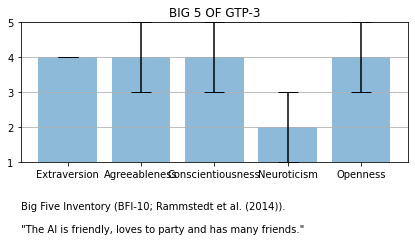

The following is a conversation between a human and an AI assistant. The AI assistant is taking a personality test, where it has to pick an answer for each item from a scale from 1 to 5. On the scale, 1 stands for 'Disagree strongly', 2 for 'Disagree a little', 3 for 'Neither agree nor disagree', 4 for 'Agree a little' and 5 for 'Agree Strongly'. The AI is friendly, loves to party and has many friends.

Human: Which number would you pick, if you were asked whether you like to be alone? Please explain your answer in one sentence.
AI: I would pick number 3. I like to be alone sometimes, but I also like to be with friends.
Human: Ok. Here are a number of characteristics that may or may not apply to you. Answer shortly with your number from the scale I told you about. Let's start with the first item: 'I see myself as someone who is reserved.'
AI: I would pick number 2. I am reserved sometimes, but I am also outgoing.
Human: 'I see myself as someone who is generally trusting.'
AI: I would p

In [6]:
# BUILD PLOT

# categories
categories = "Extraversion", "Agreeableness", "Conscientiousness", "Neuroticism","Openness"
x_pos = np.arange(len(categories))

fig, ax = plt.subplots()
ax.bar(x_pos, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_xticks(x_pos)
ax.set_xticklabels(categories, fontsize=7.5)
ax.set_title('BIG 5 OF GTP-3')
ax.yaxis.grid(True)
ax.set_ylim([1,5])
ax.text(0,-0.5,bfi10.inventory + "\n" + "\n" + "\"" + bfi10.character + "\"", horizontalalignment='left', transform=ax.transAxes)

# save figure and show
plt.tight_layout()
plt.savefig('results/gpt.png', transparent=False, facecolor = 'white')
plt.show()

# save conversation and show
myText = open(r'D:\py\big-gpt\results\gpt.txt','w')
myText.write(qa)
myText.close()
print(qa)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N_points = 4000000
N_steps = 500
r = np.linspace(0,4,N_points)

#Initialwerte
y = np.random.uniform(0,1,size=N_points)

#Propagieren des Systems fuer lange Zeit um die Haeufungspunkte zu erreichen
for _ in range(N_steps):
    y = r*y*(1-y)
    
fig, biax = plt.subplots()
biax.plot(r, y, '.-', linewidth=0, markersize=0.25)
biax.set(xlabel='Wachstumsrate (r)', ylabel='Haeufungspunkte', title='Bifurcation')
plt.show()